## 어텐션 시각화 실습 예제

### 라이브러리 준비

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
import tensorflow as tf


### 데이터 준비

In [2]:
max_features = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### 모델 정의

In [11]:
inputs = Input(shape=(maxlen,))
embedding = Embedding(max_features, 128)(inputs)
lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
attention = Attention()([lstm, lstm])
dropout = Dropout(0.5)(attention)
flatten = Flatten()(dropout)  # 추가된 Flatten 레이어
outputs = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 모델 학습

In [12]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5


625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.7524 - loss: 0.4668 - val_accuracy: 0.8916 - val_loss: 0.2713
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - accuracy: 0.9350 - loss: 0.1656 - val_accuracy: 0.8896 - val_loss: 0.2879
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.9633 - loss: 0.1022 - val_accuracy: 0.8854 - val_loss: 0.3596
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9814 - loss: 0.0525 - val_accuracy: 0.8778 - val_loss: 0.4922
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.9915 - loss: 0.0263 - val_accuracy: 0.8730 - val_loss: 0.7426


### 어텐션 가중치 추출을 위한 함수

In [16]:
# 어텐션 레이어 이름 변수에 저장
attention_layer_name = None

for layer in model.layers:
    if 'attention' in layer.name:
        attention_layer_name = layer.name
        break

if attention_layer_name:
    print(f"어텐션 레이어 이름: {attention_layer_name}")
else:
    print("어텐션 레이어를 찾을 수 없습니다.")


어텐션 레이어 이름: attention_3


In [17]:
attention_model = Model(inputs=model.input,
                        outputs=[model.output, model.get_layer(attention_layer_name).output])

def get_attention_weights(text):
    # 텍스트를 모델 입력 형식으로 변환
    x = sequence.pad_sequences([text], maxlen=maxlen)
    
    # 예측 및 주의 가중치 얻기
    prediction, attention_weights = attention_model.predict(x)
    
    return prediction[0][0], attention_weights[0]


### 어텐션 시각화 함수

In [54]:
def visualize_attention(text, attention_weights):
    # 패딩을 제외한 실제 단어에 대한 주의 가중치만 사용
    word_count = min(len(text), maxlen)
    att_weights = attention_weights[-word_count:]
    
    # 단어와 가중치 매핑
    word_att_pairs = []
    for idx, i in enumerate(text[-word_count:]):
        if i != 0:  # 패딩된 단어(0)가 아닌 경우에만 처리
            try:
                word = list(imdb.get_word_index().keys())[list(imdb.get_word_index().values()).index(i)]
                weight = att_weights[idx]
                word_att_pairs.append((word, weight))
            except ValueError:
                continue  # 단어 인덱스를 찾을 수 없는 경우 건너뛰기
    
    # L2 norm을 사용한 중요도 계산 및 정렬
    # L2 norm을 사용하면 가중치의 방향(양수/음수)에 대한 정보가 손실됩니다.
    # 따라서 단어가 긍정적인 영향을 미치는지 부정적인 영향을 미치는지는 알 수 없습니다.
    word_importance = [(word, np.linalg.norm(weight)) for word, weight in word_att_pairs]
    word_importance = sorted(word_importance, key=lambda x: x[1], reverse=True)
    
    # 상위 10개 단어 선택
    top_words = word_importance[:10]
    
    # 시각화
    words, weights = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, weights)
    plt.title('Top 10 words with highest attention weights (L2 norm)')
    plt.xlabel('Words')
    plt.ylabel('Attention Importance (L2 norm)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 상위 10개 단어와 그 중요도 출력
    print("Top 10 words with highest attention importance:")
    for word, importance in top_words:
        print(f"Word: {word}, Importance: {importance:.4f}")


### 예제 리뷰에 대한 어텐션 시각화

In [55]:
sample_review = x_test[0]
prediction, attention_weights = get_attention_weights(sample_review)
print(f"Predicted sentiment: {'Positive' if prediction > 0.5 else 'Negative'} ({prediction:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted sentiment: Negative (0.00)


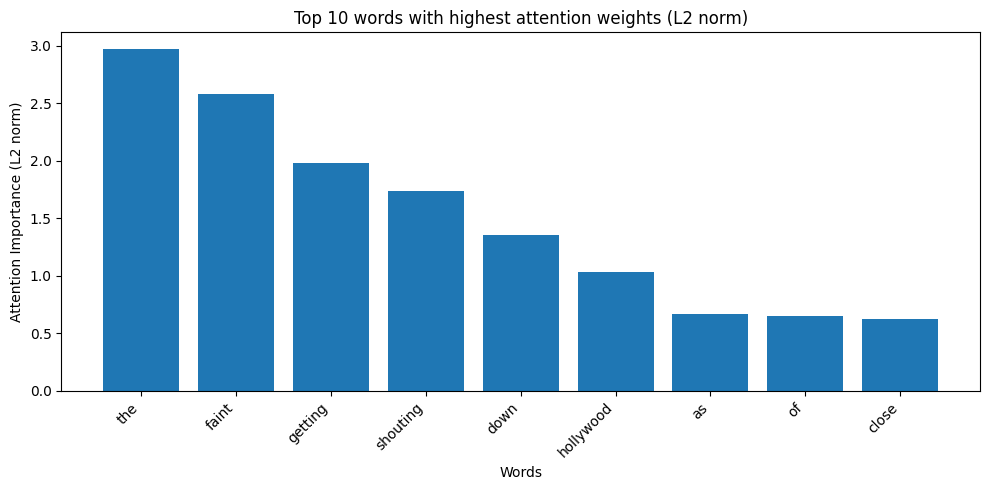

Top 10 words with highest attention importance:
Word: the, Importance: 2.9689
Word: faint, Importance: 2.5820
Word: faint, Importance: 2.4383
Word: getting, Importance: 1.9778
Word: shouting, Importance: 1.7366
Word: down, Importance: 1.3582
Word: hollywood, Importance: 1.0360
Word: as, Importance: 0.6733
Word: of, Importance: 0.6527
Word: close, Importance: 0.6221


In [56]:
visualize_attention(sample_review, attention_weights)
